In [273]:
#importing all required library's
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

#read the csv
bikeSharing_df = pd.read_csv(r'C:\Users\jg945e\Desktop\BikeSharingCaseStudy\day.csv', low_memory=False)
print(bikeSharing_df.shape) # Gives 730 Rows * 16 Columns Data 
print(bikeSharing_df.head())

(730, 16)
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  


In [274]:
## DATA CLEANING & MANIPULATION STARTS FROM HERE
## DATA CLEANING

# check for unique rows. Are there or any duplicates?
print("No. of unique rows:", bikeSharing_df.duplicated(subset=None, keep='first').count())


#Check any rows, columns are empty 
print("No. of empty rows: ", bikeSharing_df.isnull().all(axis=1).sum()) 
print("No. of empty columns: ", bikeSharing_df.isnull().all(axis=0).sum()) 

## At this point, after checking for duplicates, the unique rows is still the same. Lets retain all data assuming it's 
#necessary. 


No. of unique rows: 730
No. of empty rows:  0
No. of empty columns:  0


In [275]:
#columns with single value
uniqueColumns = bikeSharing_df.nunique()
colSingleValue = uniqueColumns[uniqueColumns.values == 1]
#print(colSingleValue.index) #Uncomment to see index 

# There are no columns with single value. At this point, we'll retain the data as is

In [276]:
#Before dropping date, let us introduce a days_old variable which indicates how old is the business
bikeSharing_df['days_old'] = (pd.to_datetime(bikeSharing_df['dteday'],format= '%d-%m-%Y') - pd.to_datetime('01-01-2018',format= '%d-%m-%Y')).dt.days

In [277]:

#Removing redundant & unwanted columns¶

#Based on the high level look at the data and the data dictionary, the following variables can be
#removed from further analysis:

#instant : Its only an index value

#dteday : This has the date, Since we already have seperate columns for 'year' & 'month',hence, we could live without this column.

#casual & registered : Both these columns contains the count of bike booked by different categories of customers. Since our objective is to find the total count of bikes and not by specific category, we will ignore these two columns. More over, we have created a new variable to have the ratio of these customer types.

#We will save the new dataframe as bikeShare_df, so that the original dataset is preserved for any future analysis/validation



bikeSharing_df.columns

bikeShare_df=bikeSharing_df[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt']]

bikeShare_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


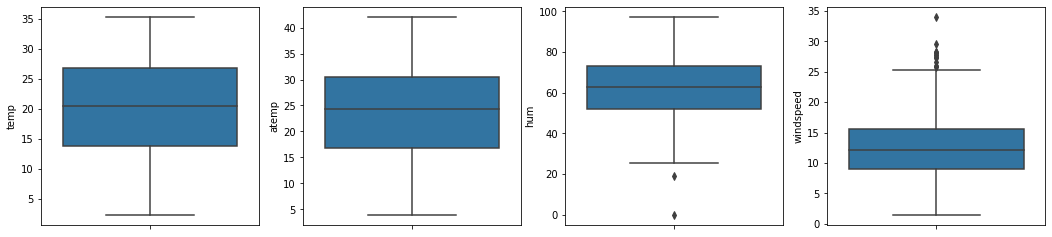

In [278]:
### Handle Outliers
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=bikeSharing_df)
    i+=1

In [279]:
# From these plots, we can see there are no outliers to be handled. We are good with not having any outliers in the data set

<Figure size 1080x2160 with 0 Axes>

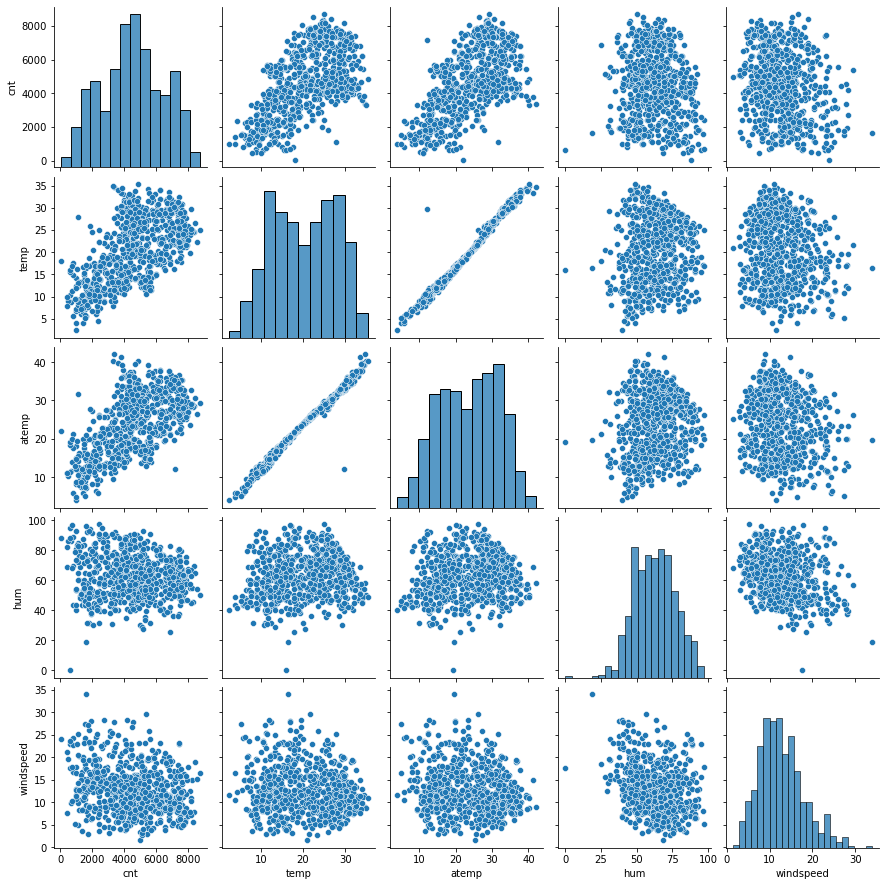

In [280]:
#Draw pairplots for continuous numeric variables using seaborn
plt.figure(figsize = (15,30))
sns.pairplot(data=bikeShare_df,vars=['cnt', 'temp', 'atemp', 'hum','windspeed'])
plt.show()

In [281]:
#temp and atemp has the highest corelation with the target variable cnt
#temp and atemp are highly co-related with each other

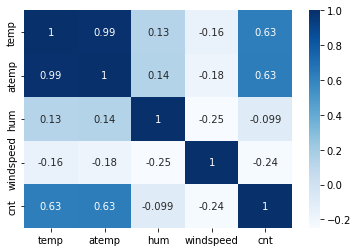

In [282]:
# Checking continuous variables relationship with each other
sns.heatmap(bikeShare_df[['temp','atemp','hum','windspeed','cnt']].corr(), cmap='Blues', annot = True)
plt.show()

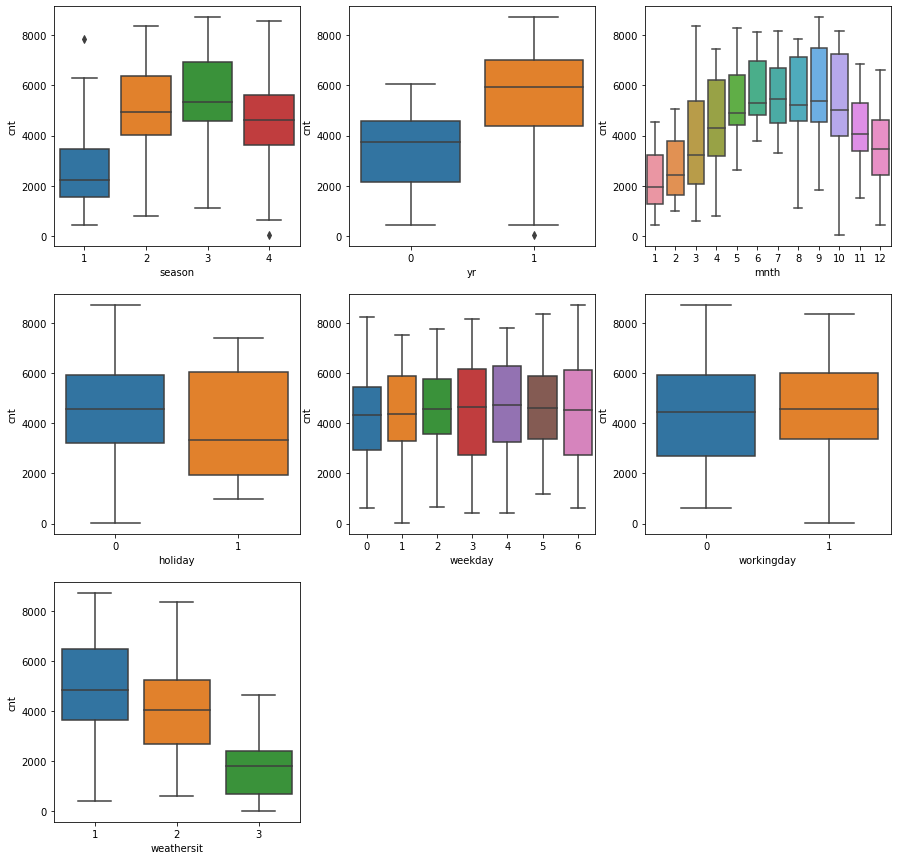

In [283]:
# Analysing Categorical Variabels with target variables
# Boxplot for categorical variables to see demands
vars_cat = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
plt.figure(figsize=(15, 15))
for i in enumerate(vars_cat):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data=bikeShare_df, x=i[1], y='cnt')
plt.show()

In [284]:
#Observations - 

    #1. Season: 3:fall has highest demand for rental bikes
    #2. I see that demand for next year has grown
    #3. Demand is continuously growing each month till June. September month has highest demand. After September, demand is decreasing
    #4. When there is a holiday, demand has decreased.
    #5. Weekday is not giving clear picture abount demand.
    #6. The clear weathershit has highest demand
    #7. During September, bike sharing is more. During the year end and beginning, it is less, could be due to extereme weather conditions.

In [285]:
#EDA starts from here

### Converting some numeric values to categorical data
bikeShare_df.season.replace({1:"spring", 2:"summer", 3:"fall", 4:"winter"},inplace = True)

bikeShare_df.weathersit.replace({1:'good',2:'moderate',3:'bad',4:'severe'},inplace = True)

bikeShare_df.mnth = bikeShare_df.mnth.replace({1: 'jan',2: 'feb',3: 'mar',4: 'apr',5: 'may',6: 'jun',
                  7: 'jul',8: 'aug',9: 'sept',10: 'oct',11: 'nov',12: 'dec'})

bikeShare_df.weekday = bikeShare_df.weekday.replace({0: 'sun',1: 'mon',2: 'tue',3: 'wed',4: 'thu',5: 'fri',6: 'sat'})
bikeShare_df.head()

season  yr mnth  holiday weekday  workingday weathersit       temp  \
0  spring   0  jan        0     sat           0   moderate  14.110847   
1  spring   0  jan        0     sun           0   moderate  14.902598   
2  spring   0  jan        0     mon           1       good   8.050924   
3  spring   0  jan        0     tue           1       good   8.200000   
4  spring   0  jan        0     wed           1       good   9.305237   

      atemp      hum  windspeed   cnt  
0  18.18125  80.5833  10.749882   985  
1  17.68695  69.6087  16.652113   801  
2   9.47025  43.7273  16.636703  1349  
3  10.60610  59.0435  10.739832  1562  
4  11.46350  43.6957  12.522300  1600

In [286]:
# Data Preparation for Linear Regression starts here
# Create dummy variables for all categorical variables

bikeShare_df = pd.get_dummies(data=bikeShare_df,columns=["season","mnth","weekday"],drop_first=True)
bikeShare_df = pd.get_dummies(data=bikeShare_df,columns=["weathersit"])

bikeShare_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_spring', 'season_summer', 'season_winter', 'mnth_aug',
       'mnth_dec', 'mnth_feb', 'mnth_jan', 'mnth_jul', 'mnth_jun', 'mnth_mar',
       'mnth_may', 'mnth_nov', 'mnth_oct', 'mnth_sept', 'weekday_mon',
       'weekday_sat', 'weekday_sun', 'weekday_thu', 'weekday_tue',
       'weekday_wed', 'weathersit_bad', 'weathersit_good',
       'weathersit_moderate'],
      dtype='object')

In [287]:
# Model Building
# Split Data into training and test
# Checking shape before splitting
bikeShare_df.shape

train, test = train_test_split(bikeShare_df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [288]:
# Feature Scaling continuous variables
# Let us scale continuous variables


scaler = MinMaxScaler()

num_vars = ['cnt','hum','windspeed','temp','atemp']

train[num_vars] = scaler.fit_transform(train[num_vars])

In [289]:
train.head()

yr  holiday  workingday      temp     atemp       hum  windspeed  \
653   1        0           1  0.509887  0.501133  0.575354   0.300794   
576   1        0           1  0.815169  0.766351  0.725633   0.264686   
426   1        0           0  0.442393  0.438975  0.640189   0.255342   
728   1        0           0  0.245101  0.200348  0.498067   0.663106   
482   1        0           0  0.395666  0.391735  0.504508   0.188475   

          cnt  season_spring  season_summer  ...  mnth_sept  weekday_mon  \
653  0.864243              0              0  ...          0            0   
576  0.827658              0              0  ...          0            0   
426  0.465255              1              0  ...          0            0   
728  0.204096              1              0  ...          0            0   
482  0.482973              0              1  ...          0            0   

     weekday_sat  weekday_sun  weekday_thu  weekday_tue  weekday_wed  \
653            0            0            0            1            0   
576            0            0            0            1            0   
426            1            0            0            0            0   
728            0            1            0            0            0   
482            1            0            0            0            0   

     weathersit_bad  weathersit_good  weathersit_moderate  
653               0                1                    0  
576               0                1                    0  
426               0                0                    1  
728               0                1                    0  
482               0                0                    1  

[5 rows x 31 columns]

In [290]:
train.describe()

yr     holiday  workingday        temp       atemp         hum  \
count  510.000000  510.000000  510.000000  510.000000  510.000000  510.000000   
mean     0.507843    0.025490    0.676471    0.537262    0.512989    0.650369   
std      0.500429    0.157763    0.468282    0.225844    0.212385    0.145882   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.339853    0.332086    0.538643   
50%      1.000000    0.000000    1.000000    0.540519    0.526811    0.653714   
75%      1.000000    0.000000    1.000000    0.735215    0.688457    0.754830   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

        windspeed         cnt  season_spring  season_summer  ...   mnth_sept  \
count  510.000000  510.000000     510.000000     510.000000  ...  510.000000   
mean     0.320768    0.513620       0.243137       0.245098  ...    0.080392   
std      0.169797    0.224593       0.429398       0.430568  ...    0.272166   
min      0.000000    0.000000       0.000000       0.000000  ...    0.000000   
25%      0.199179    0.356420       0.000000       0.000000  ...    0.000000   
50%      0.296763    0.518638       0.000000       0.000000  ...    0.000000   
75%      0.414447    0.684710       0.000000       0.000000  ...    0.000000   
max      1.000000    1.000000       1.000000       1.000000  ...    1.000000   

       weekday_mon  weekday_sat  weekday_sun  weekday_thu  weekday_tue  \
count   510.000000   510.000000   510.000000   510.000000   510.000000   
mean      0.150980     0.154902     0.143137     0.133333     0.131373   
std       0.358381     0.362166     0.350557     0.340268     0.338139   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       weekday_wed  weathersit_bad  weathersit_good  weathersit_moderate  
count   510.000000      510.000000       510.000000           510.000000  
mean      0.158824        0.029412         0.627451             0.343137  
std       0.365870        0.169124         0.483958             0.475223  
min       0.000000        0.000000         0.000000             0.000000  
25%       0.000000        0.000000         0.000000             0.000000  
50%       0.000000        0.000000         1.000000             0.000000  
75%       0.000000        0.000000         1.000000             1.000000  
max       1.000000        1.000000         1.000000             1.000000  

[8 rows x 31 columns]

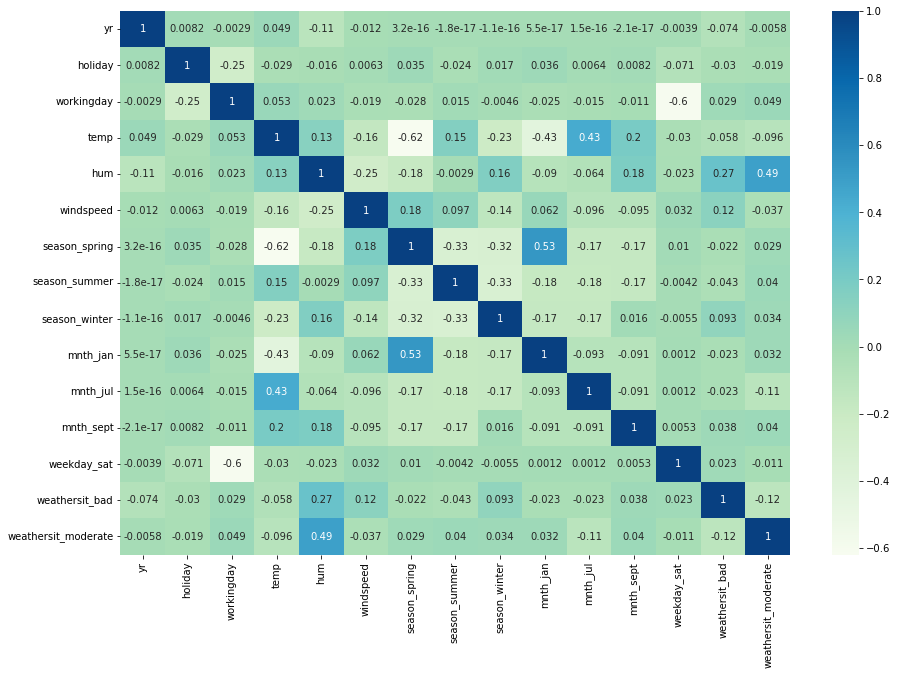

In [291]:
# Checking correlation of features selected by RFE with target column. 
# Also to check impact of different features on target.
plt.figure(figsize = (15,10))
sns.heatmap(bikeShare_df[['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter', 'mnth_jan', 'mnth_jul', 'mnth_sept', 'weekday_sat',
       'weathersit_bad', 'weathersit_moderate']].corr(), cmap='GnBu', annot=True)
plt.show()

In [292]:

#Dividing into X and Y sets for the model building

y_train = train.pop('cnt')
X_train = train



In [304]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [305]:
#Columns selected by RFE and their weights
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('mnth_aug', False, 8),
 ('mnth_dec', False, 4),
 ('mnth_feb', False, 5),
 ('mnth_jan', False, 2),
 ('mnth_jul', True, 1),
 ('mnth_jun', False, 14),
 ('mnth_mar', False, 12),
 ('mnth_may', False, 7),
 ('mnth_nov', False, 3),
 ('mnth_oct', False, 11),
 ('mnth_sept', True, 1),
 ('weekday_mon', False, 10),
 ('weekday_sat', True, 1),
 ('weekday_sun', False, 9),
 ('weekday_thu', False, 13),
 ('weekday_tue', False, 15),
 ('weekday_wed', False, 16),
 ('weathersit_bad', True, 1),
 ('weathersit_good', True, 1),
 ('weathersit_moderate', True, 1)]

In [306]:
# Build Model
# Model 1 - Starting with all the columns selected by RFE
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'season_spring', 'season_summer', 'season_winter', 'mnth_jul',
       'mnth_sept', 'weekday_sat', 'weathersit_bad', 'weathersit_good',
       'weathersit_moderate'],
      dtype='object')

In [307]:
X_train.columns[~rfe.support_]

Index(['atemp', 'mnth_aug', 'mnth_dec', 'mnth_feb', 'mnth_jan', 'mnth_jun',
       'mnth_mar', 'mnth_may', 'mnth_nov', 'mnth_oct', 'weekday_mon',
       'weekday_sun', 'weekday_thu', 'weekday_tue', 'weekday_wed'],
      dtype='object')

In [308]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]


In [309]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

In [310]:
# Create a first fitted model
lm = sm.OLS(y_train,X_train_rfe).fit()

In [311]:
# Check the parameters obtained
lm.params


const                  0.103490
yr                     0.229738
holiday               -0.059434
workingday             0.043216
temp                   0.527819
hum                   -0.159467
windspeed             -0.180601
season_spring         -0.055434
season_summer          0.052613
season_winter          0.100294
mnth_jul              -0.054881
mnth_sept              0.081773
weekday_sat            0.053203
weathersit_bad        -0.110442
weathersit_good        0.135890
weathersit_moderate    0.078042
dtype: float64

In [312]:
# Print a summary of the linear regression model obtained
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.3
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          1.13e-191
Time:                        20:51:41   Log-Likelihood:                 517.87
No. Observations:                 510   AIC:                            -1006.
Df Residuals:                     495   BIC:                            -942.2
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1035    

In [313]:
# Model 2 - Rebuilding the model without 'weekday_Saturday'
X_train_new = X_train_rfe.drop(["weekday_sat"], axis = 1)



In [314]:

# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

lm = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model



lm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.3
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          5.58e-190
Time:                        20:52:12   Log-Likelihood:                 511.05
No. Observations:                 510   AIC:                            -994.1
Df Residuals:                     496   BIC:                            -934.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1311      0.029      4.517      0.000       0.074       0.188
yr                      0.2290      0.008     28.227      0.000       0.213       0.245
holiday                -0.0870      0.026     -3.322      0.001      -0.138      -0.036
workingday              0.0155      0.009      1.754      0.080      -0.002       0.033
temp                    0.5286      0.034     15.725      0.000       0.463       0.595
hum                    -0.1701      0.038     -4.510      0.000      -0.244      -0.096
windspeed              -0.1801      0.026     -7.005      0.000      -0.231      -0.130
season_spring          -0.0559      0.021     -2.684      0.008      -0.097      -0.015
season_summer           0.0520      0.015      3.469      0.001       0.023       0.081
season_winter           0.0997      0.017      5.783      0.000       0.066       0.134
mnth_jul               -0.0562      0.018     -3.073      0.002      -0.092      -0.020
mnth_sept               0.0829      0.017      4.963      0.000       0.050       0.116
weathersit_bad         -0.0979      0.022     -4.400      0.000      -0.142      -0.054
weathersit_good         0.1419      0.010     13.712      0.000       0.122       0.162
weathersit_moderate     0.0871      0.012      7.011      0.000       0.063       0.111
==============================================================================
Omnibus:                       53.760   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.221
Skew:                          -0.538   Prob(JB):                     2.63e-30
Kurtosis:                       5.292   Cond. No.                     1.07e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.46e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [315]:
# Checking VIF for multicollinearity
# Calculate the VIFs for the new model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
12       weathersit_bad   inf
13      weathersit_good   inf
14  weathersit_moderate   inf
7         season_spring  5.02
4                  temp  3.62
9         season_winter  3.49
8         season_summer  2.61
5                   hum  1.90
10             mnth_jul  1.49
11            mnth_sept  1.30
6             windspeed  1.20
2               holiday  1.07
3            workingday  1.07
1                    yr  1.03
0                 const  0.00

In [316]:
#We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.
X_train_new = X_train_new.drop(['const'], axis=1)

In [317]:
# Calculate the VIFs for the new model again
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


Features    VIF
12      weathersit_good  48.26
13  weathersit_moderate  31.96
6         season_spring   5.02
11       weathersit_bad   4.18
3                  temp   3.62
8         season_winter   3.49
7         season_summer   2.61
4                   hum   1.90
9              mnth_jul   1.49
10            mnth_sept   1.30
5             windspeed   1.20
1               holiday   1.07
2            workingday   1.07
0                    yr   1.03

In [318]:
#Model -3 (final model)
# Dropping the variable hum 
X_train_new = X_train_new.drop(['hum'], axis=1)

In [319]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_new)

# Create a first fitted model
lm = sm.OLS(y_train,X_train_lm).fit()   

In [320]:

# Check the summary
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     212.4
Date:                Tue, 15 Feb 2022   Prob (F-statistic):          7.65e-187
Time:                        20:55:18   Log-Likelihood:                 500.81
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     497   BIC:                            -920.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0493    

In [321]:
# Calculate the VIFs for the new model again
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
11      weathersit_good  34.44
12  weathersit_moderate  18.74
5         season_spring   4.95
3                  temp   3.38
7         season_winter   3.35
10       weathersit_bad   2.62
6         season_summer   2.59
8              mnth_jul   1.48
9             mnth_sept   1.29
4             windspeed   1.09
1               holiday   1.07
2            workingday   1.07
0                    yr   1.02

In [322]:
#Residual Analysis of the train data
y_train_cnt = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

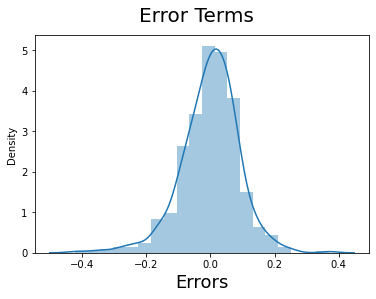

In [323]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

In [324]:
# Making Predictions Using the Final Model

#Applying the scaling on the test sets
num_vars = ['cnt','hum','windspeed','temp','atemp']
test[num_vars] = scaler.transform(test[num_vars])
test.describe()


yr     holiday  workingday        temp       atemp         hum  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.479452    0.036530    0.698630    0.558941    0.532991    0.638508   
std      0.500722    0.188034    0.459904    0.233698    0.217888    0.148974   
min      0.000000    0.000000    0.000000    0.046591    0.025950    0.261915   
25%      0.000000    0.000000    0.000000    0.354650    0.344751    0.527265   
50%      0.000000    0.000000    1.000000    0.558691    0.549198    0.627737   
75%      1.000000    0.000000    1.000000    0.759096    0.714132    0.743928   
max      1.000000    1.000000    1.000000    0.984424    0.980934    1.002146   

        windspeed         cnt  season_spring  season_summer  ...   mnth_sept  \
count  219.000000  219.000000     219.000000     219.000000  ...  219.000000   
mean     0.313350    0.520592       0.255708       0.264840  ...    0.086758   
std      0.159947    0.218435       0.437258       0.442259  ...    0.282125   
min     -0.042808    0.048205       0.000000       0.000000  ...    0.000000   
25%      0.198517    0.377531       0.000000       0.000000  ...    0.000000   
50%      0.299459    0.524275       0.000000       0.000000  ...    0.000000   
75%      0.403048    0.672745       1.000000       1.000000  ...    0.000000   
max      0.807474    0.963300       1.000000       1.000000  ...    1.000000   

       weekday_mon  weekday_sat  weekday_sun  weekday_thu  weekday_tue  \
count   219.000000   219.000000   219.000000   219.000000   219.000000   
mean      0.127854     0.118721     0.146119     0.164384     0.164384   
std       0.334692     0.324202     0.354034     0.371472     0.371472   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       weekday_wed  weathersit_bad  weathersit_good  weathersit_moderate  
count   219.000000      219.000000       219.000000           219.000000  
mean      0.100457        0.027397         0.652968             0.319635  
std       0.301297        0.163612         0.477117             0.467403  
min       0.000000        0.000000         0.000000             0.000000  
25%       0.000000        0.000000         0.000000             0.000000  
50%       0.000000        0.000000         1.000000             0.000000  
75%       0.000000        0.000000         1.000000             1.000000  
max       1.000000        1.000000         1.000000             1.000000  

[8 rows x 31 columns]

In [325]:
# Dividing into X_test and y_test
y_test = test.pop('cnt')
X_test = test

In [326]:
# Adding constant variable to test dataframe
X_test = sm.add_constant(X_test)

In [327]:
# predicting using values used by the final model
test_col = X_train_lm.columns
X_test=X_test[test_col[1:]]
# Adding constant variable to test dataframe
X_test = sm.add_constant(X_test)

X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 184 to 72
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   const                219 non-null    float64
 1   yr                   219 non-null    int64  
 2   holiday              219 non-null    int64  
 3   workingday           219 non-null    int64  
 4   temp                 219 non-null    float64
 5   windspeed            219 non-null    float64
 6   season_spring        219 non-null    uint8  
 7   season_summer        219 non-null    uint8  
 8   season_winter        219 non-null    uint8  
 9   mnth_jul             219 non-null    uint8  
 10  mnth_sept            219 non-null    uint8  
 11  weathersit_bad       219 non-null    uint8  
 12  weathersit_good      219 non-null    uint8  
 13  weathersit_moderate  219 non-null    uint8  
dtypes: float64(3), int64(3), uint8(8)
memory usage: 13.7 KB


In [328]:
# Making predictions using the fourth model

y_pred = lm.predict(X_test)

In [329]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8055699418949736

In [330]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
mse

0.009234612738404781

Text(0, 0.5, 'y_pred')

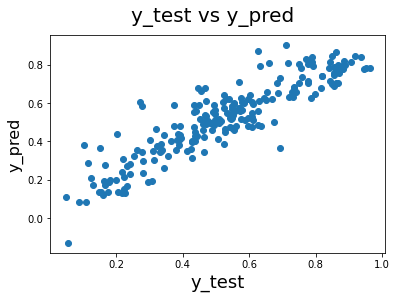

In [331]:
# Model Evaluation
# Let's now plot the graph for actual versus predicted values.
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)      

In [335]:
param = pd.DataFrame(lm.params)
param.insert(0,'Variables',param.index)
param.rename(columns = {0:'Coefficient value'},inplace = True)
param['index'] = list(range(0,14))
param.set_index('index',inplace = True)
param.sort_values(by = 'Coefficient value',ascending = False,inplace = True)
param

Variables  Coefficient value
index                                        
4                     temp           0.490248
1                       yr           0.233102
12         weathersit_good           0.139307
8            season_winter           0.084154
10               mnth_sept           0.076575
13     weathersit_moderate           0.057194
0                    const           0.049290
7            season_summer           0.045398
3               workingday           0.016044
9                 mnth_jul          -0.051104
6            season_spring          -0.066531
2                  holiday          -0.087227
5                windspeed          -0.146306
11          weathersit_bad          -0.147210

In [ ]:
# Observation and Final Conclusion using Model 3 as final model


# We can see that the equation of our best fitted line is:

#cnt = 0.199648 + 0.490248 X temp + 0.233102 X yr + 0.084154 X seasonWinter - 0.0665312 X season Spring + 0.084154 X season_Winter -0.051104 X mnth_Jul + 0.076575 X mnth_Sep -0.147210 X weathersit_bad 0.057194 X weathersit_moderate -0.087227 X holiday -0.146306 X windspeed
#All the positive coefficients like temp,season_Summer indicate that an increase in these values will lead to an increase in the value of cnt.
#All the negative coefficients indicate that an increase in these values will lead to an decrease in the value of cnt.

#Temp is the most significant with the largest coefficient.
#Followed by weathersit_Light Snow & Rain.
#Bike rentals is more for the month of september
#The rentals reduce during holidays

#This indicates that the bike rentals is majorly affected by temperature,season and month.
